In [65]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [20]:
adults = pd.read_csv('adult.csv')
adults.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [21]:
adults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Некоторые категориальные фичи содержат вместо пропусков значение '?':

In [22]:
adults['workclass'].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [23]:
adults['occupation'].value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
?                    2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

In [24]:
adults['native-country'].value_counts()

United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Nicaragua                        49
Greece                           49
Peru                        

Заполним пропуски модой по столбцу:

In [26]:
adults.loc[adults['workclass'] == '?', 'workclass'] = adults['workclass'].value_counts().index[0]
adults.loc[adults['occupation'] == '?', 'occupation'] = adults['occupation'].value_counts().index[0]
adults.loc[adults['native-country'] == '?', 'native-country'] = adults['native-country'].value_counts().index[0]

Переведем категориальные переменные к виду 0/1 (кроме целевой переменной income)

In [27]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship',
                       'race', 'gender', 'native-country']
adults = pd.get_dummies(adults, columns = categorical_features)

In [28]:
adults['income'] = adults['income'].map({'<=50K': 0, '>50K': 1})

In [29]:
adults.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,103497,10,0,0,30,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Разделим данные на трейн/тест

In [31]:
X_train, X_test, y_train, y_test = train_test_split(adults.drop('income', axis=1), adults['income'], test_size=0.3,
                                                   random_state=66)

In [32]:
X_train.shape, X_test.shape

((34189, 105), (14653, 105))

Значение AUC для разных параметров LogisticRegression

In [50]:
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [51]:
params = []
curves = []
auc = []

In [52]:
for p in penalty:
    for c in C:
        log_reg = LogisticRegression(C = c, penalty = p, random_state = 12).fit(X_train, y_train)
        y_probas = log_reg.predict_proba(X_test)[:, 1]
        
        params.append((p, c))
        curves.append(roc_curve(y_test, y_probas))
        auc.append(roc_auc_score(y_test, y_probas))       

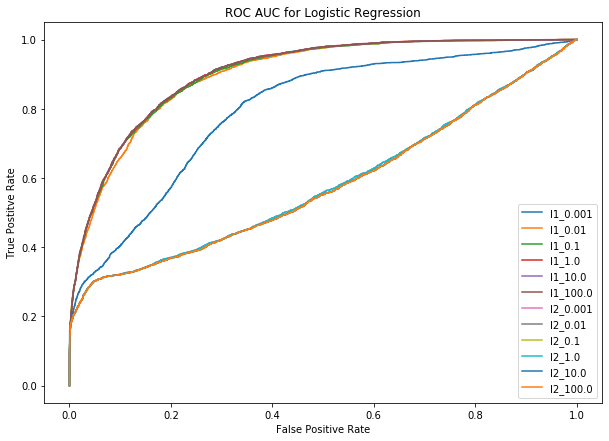

In [53]:
plt.figure(figsize=(10, 7))

for i in range(len(params)):
    plt.plot(curves[i][0], curves[i][1], label='{}_{}'.format(params[i][0], params[i][1]))

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Postitve Rate')
plt.title('ROC AUC for Logistic Regression')
plt.show()

In [54]:
for i in range(len(params)):
    print('{}_{}: {}'.format(params[i][0], params[i][1], auc[i]))

l1_0.001: 0.7941184914009816
l1_0.01: 0.8980777224384172
l1_0.1: 0.9012413345596355
l1_1.0: 0.903202653471807
l1_10.0: 0.9030439368524837
l1_100.0: 0.9030074467188645
l2_0.001: 0.5820906114957836
l2_0.01: 0.5793263807946448
l2_0.1: 0.5793255561588568
l2_1.0: 0.5820779842602798
l2_10.0: 0.5793257107780672
l2_100.0: 0.5793255561588568


In [64]:
max_index = np.argmax(auc)
print('Максимальное значение AUC при {}_{} : {}'.format(params[max_index][0], params[max_index][1], auc[max_index]))

Максимальное значение AUC при l1_1.0 : 0.903202653471807


Значение AUC для разных параметров DecisionTreeClassifier

In [77]:
max_depth = [5, 15, 25]
min_samples_leaf = [5, 10]
max_features = [80, 90, 100]

In [78]:
params = []
curves = []
auc = []

In [79]:
for depth in max_depth:
    for samples_leaf in min_samples_leaf:
        for features in max_features:
            tree = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = samples_leaf,
                                          max_features = features, random_state = 55).fit(X_train, y_train)
            y_probas = tree.predict_proba(X_test)[:, 1]

            params.append((depth, samples_leaf, features))
            curves.append(roc_curve(y_test, y_probas))
            auc.append(roc_auc_score(y_test, y_probas))       

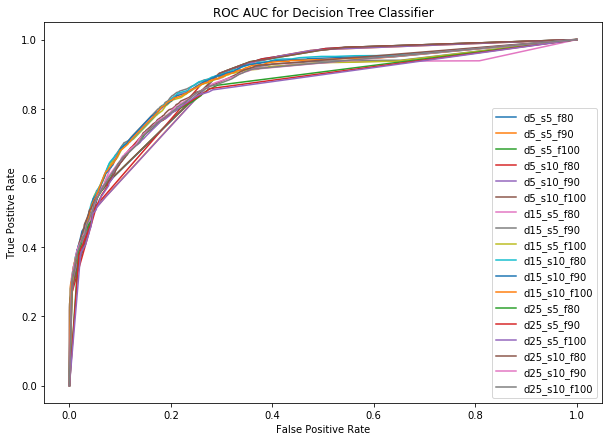

In [80]:
plt.figure(figsize=(10, 7))

for i in range(len(params)):
    plt.plot(curves[i][0], curves[i][1], label='d{}_s{}_f{}'.format(params[i][0], params[i][1], params[i][2]))

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Postitve Rate')
plt.title('ROC AUC for Decision Tree Classifier')
plt.show()

In [81]:
for i in range(len(params)):
    print('d{}_s{}_f{}: {}'.format(params[i][0], params[i][1], params[i][2], auc[i]))

d5_s5_f80: 0.8838277067832221
d5_s5_f90: 0.8792089475044589
d5_s5_f100: 0.8840487478292107
d5_s10_f80: 0.882435038671553
d5_s10_f90: 0.8789322177729113
d5_s10_f100: 0.8839308249115256
d15_s5_f80: 0.8713093360883041
d15_s5_f90: 0.8795703054837506
d15_s5_f100: 0.8752322702661333
d15_s10_f80: 0.8867062010807367
d15_s10_f90: 0.8842133657483918
d15_s10_f100: 0.882254417664111
d25_s5_f80: 0.8569394905451642
d25_s5_f90: 0.8537980147408801
d25_s5_f100: 0.850440136466915
d25_s10_f80: 0.8769814516218395
d25_s10_f90: 0.873275293576783
d25_s10_f100: 0.8724751391637318


In [82]:
max_index = np.argmax(auc)
print('Максимальное значение AUC при d{}_s{}_f{} : {}'.format(params[max_index][0], 
                                                              params[max_index][1], 
                                                              params[max_index][2],
                                                              auc[max_index]))

Максимальное значение AUC при d15_s10_f80 : 0.8867062010807367
